In [64]:
testing = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [65]:
import tensorflow as tf
import numpy as np
import time
import collections
import pandas
from tqdm.notebook import tqdm
import json
import random
import matplotlib.pyplot as plt
import re
import os
#from PIL import Image

In [66]:
top_k = 12000

In [67]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(1000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [68]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [69]:
if testing:
    pos_encoding = positional_encoding(64, d_model=256)
    plt.figure(figsize=(24,20))
    plt.imshow(pos_encoding[0])
    plt.xlabel('Depth in Encoding Vector')
    plt.ylabel('Position in Sequence')

In [70]:
BATCH_SIZE = 4
num_patches = 576
patch_size = 16

In [71]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model=256, dff=2048, dropout=.1, name=None):
        super().__init__(name=name)
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.layer_norm1 = tf.keras.layers.LayerNormalization()
        self.layer_norm2 = tf.keras.layers.LayerNormalization()

    def call(self, x, training, mask):
        attention_weights, _ = self.self_attention(x, x, attention_mask=mask,
                                                    return_attention_scores=True)
        normalized = self.layer_norm1(x + attention_weights)
        x = self.fc2(self.dropout(self.fc1(normalized), training=training))
        return self.layer_norm2(x + normalized)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model)

        self.fc1 = tf.keras.layers.Dense(dff, activation=tf.keras.activations.gelu)
        self.fc2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        seq_len = x.shape[1]
        attn1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask,
                                              return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        #enc_output = enc_output[:, :seq_len, :]
        attn2, attn_weights_block2 = self.mha2(
            out1, enc_output, enc_output, attention_mask=padding_mask,
                                    return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.fc2(self.dropout3(self.fc1(out2), training=training))
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [72]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(tf.range(start=0, limit=self.num_patches, delta=1), 0)
        projection = self.projection(patch)
        embeddings = self.position_embedding(positions)
        encoded = projection + embeddings
        return encoded

In [73]:
if testing:
    img_array = tf.random.uniform([64,384,384,3], minval=0, maxval=1)
    print(img_array.shape)
    patches = Patches(patch_size)(img_array)
    encoded = PatchEncoder(num_patches, 256)(patches)
    encoded.shape

In [74]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_positional_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.patches = Patches(16)
        self.patch_encoder = PatchEncoder(num_patches, d_model)
        self.pos_encoding = positional_encoding(maximum_positional_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(num_heads, d_model, dff, dropout=rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training, mask):
        patches = self.patches(x)
        x = self.patch_encoder(patches)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [75]:
if testing:
    sample_encoder = Encoder(num_layers=1, d_model=256, num_heads=8,
                          dff=1024, maximum_positional_encoding=10000)
    temp_input = tf.random.uniform((BATCH_SIZE,384,384,3), dtype=tf.float32, minval=0, maxval=1.)
    sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
    print(sample_encoder_output.shape)

In [76]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
    #return seq[:, :, tf.newaxis]
create_padding_mask([[5, 4, 3, 2, 1, 0, 0, 0, 0, 0]])

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [77]:
def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask # (seq_len, seq_len)
create_look_ahead_mask(4)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

In [78]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        #print('Seq length:', seq_len)
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #print('Sequence shape:', x.shape)
        #print('Encoder output shape:', enc_output.shape)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        #print('Before decoder layers shape:', x.shape)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [79]:
if testing:
    sample_decoder = Decoder(num_layers=2, d_model=256, num_heads=8,
                          dff=1024, target_vocab_size=8000,
                          maximum_position_encoding=5000)
    temp_input = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)
    padding_mask = tf.random.uniform((BATCH_SIZE, 74, 576), dtype=tf.int32, minval=0, maxval=1)
    look_ahead_mask = create_look_ahead_mask(74)
    output, attn = sample_decoder(temp_input,
                                enc_output=sample_encoder_output,
                                training=False,
                                look_ahead_mask=look_ahead_mask,
                                padding_mask=padding_mask)

    print(output.shape, attn['decoder_layer1_block2'].shape)

In [80]:
if testing:
    mha = tf.keras.layers.MultiHeadAttention(8, 256)
    enc_output = tf.random.uniform([64,576,256])
    dec_latent = tf.random.uniform([64,74,256])
    mask = tf.random.uniform([64,74,576], dtype=tf.float32, maxval=1)
    print(mha(dec_latent, enc_output, enc_output, mask).shape)

In [81]:
def augmentation_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-.125,.125)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(.5,1.5))
    ])
    return model

In [82]:
class Transformer(tf.keras.Model):
    def __init__(self, num_encoders, num_decoders, d_model, num_heads, dff,
               maximum_positional_encoding, target_vocab_size, target, rate=0.1):
        super(Transformer, self).__init__()
        self.augmenter = augmentation_model()
        self.tokenizer = Encoder(num_encoders, d_model, num_heads, dff,
                                maximum_positional_encoding, rate)
        self.decoder = Decoder(num_decoders, d_model, num_heads, dff,
                               target_vocab_size, target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    def call(self, x):
        inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask = x
        enc_output = self.tokenizer(self.augmenter(inp), training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [83]:
if testing:
    sample_transformer = Transformer(
      num_encoders=1, num_decoders=1, d_model = 256, num_heads = 8, dff = 2048,
      target_vocab_size = 8000, target=6000, maximum_positional_encoding=512)

    temp_input = tf.random.uniform((BATCH_SIZE,16,16,3), dtype=tf.int64, minval=0, maxval=200)
    temp_target = tf.random.uniform((BATCH_SIZE, 74), dtype=tf.int64, minval=0, maxval=200)

    fn_out, _ = sample_transformer((temp_input, temp_target, False,
                                None,
                                None,
                                None))

    print(fn_out.shape)

In [84]:
def create_masks(tar):
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_target_padding_mask

In [85]:
class SequenceLoss(tf.keras.losses.Loss):
    def call(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = tfa.seq2seq.SequenceLoss()

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

In [86]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [87]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=-1), dtype=real.dtype))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [88]:
real_example = tf.convert_to_tensor([[79,80,50, 0, 0, 0]])
logits = tf.one_hot([79,80,50, 3, 3, 3], 8000) * 1
pred_example = tf.expand_dims(logits, 0)
accuracy_function(real_example, pred_example), loss_function(real_example, pred_example)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.987412>)

In [89]:
logits = tf.one_hot([3,3,3, 3, 3, 3], 8000) * 1
print(logits[0][:5])
pred_example = tf.expand_dims(logits, 0)
accuracy_function(real_example, pred_example), loss_function(real_example, pred_example)

tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.9874115>)

In [90]:
d_model = 768
dff = 2048
num_heads = 10

In [28]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

RuntimeError: Visible devices cannot be modified after being initialized

In [92]:
with tf.device('/device:CPU:0'):
    transformer = Transformer(num_encoders=12, num_decoders=4, d_model=d_model, num_heads = num_heads, dff = dff,
        target_vocab_size = top_k, target=top_k, maximum_positional_encoding=32, rate=.3)

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, baseline_lr = 1e-4):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.baseline_lr = baseline_lr

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        val = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) * self.baseline_lr) / 1e-3

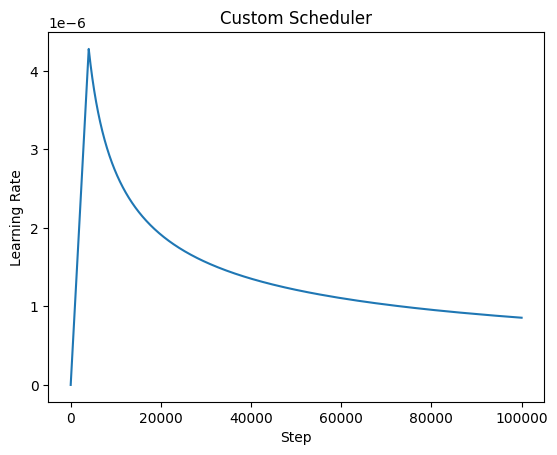

In [94]:
learning_rate = CustomSchedule(d_model, baseline_lr=7.5e-6)
plt.plot(learning_rate(tf.range(0, limit=1e5)))
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Custom Scheduler')
plt.show()

In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [96]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
    print(ckpt_manager.latest_checkpoint)

Latest checkpoint restored!!
./checkpoints/train\ckpt-4


In [97]:
DEFAULT_TOP_K = 12000

In [98]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(tf.image.resize(img, (384, 384)), tf.float32) / 255.
    return img, image_path

In [99]:
def get_data(path, annotations_json, is_roast=False, split=[.8,.1,.1], subset=None, tokenizer=None, 
             batch_size=16, return_text=False):
    with open(annotations_json, 'r') as f:
        annotations = json.load(f)
    
    image_path_to_caption = collections.defaultdict(list)
    if is_roast:
        for entry in annotations['info']:
            for roast in entry['Roasts']:
                if roast != 'removed':
                    temp_caption = re.sub('([.,\'"!?()0-9])', r' \1 ', roast)
                    caption = f"<start> {temp_caption} <end>"
                    image_path = path + '{}.jpg'.format(entry['ID'])
                    image_path_to_caption[image_path].append(caption)
    else:
        for val in annotations['annotations']:
            temp_caption = re.sub('([.,\'"!?()0-9])', r' \1 ', val['caption'])
            caption = f"<start> {temp_caption} <end>"
            image_path = path + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
            image_path_to_caption[image_path].append(caption)
    
    image_paths = list(image_path_to_caption.keys())
    random.shuffle(image_paths)
    
    usable_image_paths = image_paths if not subset else image_paths[:subset]
    
    num = len(usable_image_paths)
    train_image_paths = usable_image_paths[:int(num*split[0])]
    test_image_paths = usable_image_paths[int(num*split[0]):int(num*split[0]+num*split[1])]
    val_image_paths = usable_image_paths[int(num*split[0]+num*split[1]):]
    
    if not tokenizer:
        tokenizer = create_tokenizer_from_texts(DEFAULT_TOP_K, [image_path_to_caption[path] for path in train_image_paths])
    
    train_dataset = get_dataset(train_image_paths, image_path_to_caption, batch_size, tokenizer)
    test_dataset = get_dataset(test_image_paths, image_path_to_caption, batch_size, tokenizer)
    val_dataset = get_dataset(val_image_paths, image_path_to_caption, batch_size, tokenizer)
    if return_text:
        return (train_dataset, test_dataset, val_dataset), tokenizer, [image_path_to_caption[path] for path in train_image_paths]
    return (train_dataset, test_dataset, val_dataset), tokenizer

def get_dataset(image_paths, image_path_to_caption, batch_size, tokenizer):
    captions = []
    img_name_vector = []
    
    for image_path in image_paths:
        caption_list = image_path_to_caption[image_path]
        captions.extend(caption_list)
        img_name_vector.extend([image_path] * len(caption_list))
        
    sequences = tokenizer.texts_to_sequences(captions)
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=32)
    #cap_vector = sequences
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    BUFFER_SIZE = 1000
    dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_vector))
    dataset = dataset.map(lambda x, y: (load_image(x)[0], y))
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE, seed=40).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_tokenizer_from_texts(top_k, texts):
    total_texts = []
    for text in texts:
        for t in text:
            total_texts.append(t)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    #tokenizer.word_index['<end>'] = top_k-1
    #tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def create_tokenizer_from_file(top_k, filename):
    total_texts = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            total_texts.append(line)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                     oov_token='<unk>',
                                                     filters='#$%&*+.,-/;=@[\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(total_texts)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    #tokenizer.word_index['<end>'] = top_k-1
    #tokenizer.index_word[top_k-1] = '<end>'
    return tokenizer

def save_all_train_annotations(filename, texts):
    with open(filename, 'w', encoding='utf-8') as f:
        for text in texts:
            f.writelines([t+'\n' for t in text])

In [100]:
re.sub('([.,\'"!?()0-9])', r' \1 ', 'Testing! All aboard? We (not they) are "testing" [now]. Let\'s go, buddy. 123456')

'Testing !  All aboard ?  We  ( not they )  are  " testing "  [now] .  Let \' s go ,  buddy .   1  2  3  4  5  6 '

In [101]:
roast_annotation_file = './reddit_roasts.json'
REDDIT_PATH = './faces/faces/'

In [102]:
import pickle

with open('roast_tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [103]:
def show_example(dataset, tokenizer):
    for (imgs, captions) in dataset.take(1):
        img = imgs[0]
        plt.imshow(imgs[0])
        plt.show()
        print('Sequence:', captions[0])
        print('Caption:', [tokenizer.index_word[i] for i in captions[0].numpy() if i != 0])
    return img

In [104]:
(roast_train_dataset, roast_test_dataset, roast_val_dataset), roast_tokenizer = get_data(REDDIT_PATH, roast_annotation_file, is_roast=True,
                                                                     subset=None, batch_size=BATCH_SIZE,
                                                                           tokenizer=tokenizer)

In [105]:
roast_train_dataset.element_spec

(TensorSpec(shape=(4, 384, 384, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(4, 32), dtype=tf.int32, name=None))

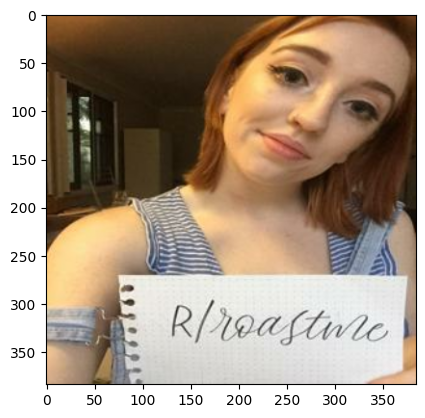

Sequence: tf.Tensor(
[   2    4 2079    8  102   96    8  892    9  126    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int32)
Caption: ['<start>', 'you', 'deserve', 'to', 'go', 'back', 'to', 'feeling', 'like', 'shit', '<end>']


In [106]:
show_example(roast_train_dataset, roast_tokenizer);

In [107]:
train_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
]

test_step_signature = [
    tf.TensorSpec(shape=(BATCH_SIZE, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    combined_mask, dec_padding_mask = create_masks(tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer((inp, tar_inp,
                                 True,
                                 None,
                                 combined_mask,
                                 None))
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))
    return tf.argmax(predictions, axis=-1)

@tf.function(input_signature=test_step_signature)
def test_step(inp, target):
    tar_inp = target[:, :-1]
    tar_real = target[:, 1:]
    
    combined_mask, dec_padding_mask = create_masks(tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer((inp, tar_inp,
                                    False,
                                    None,
                                    combined_mask,
                                    None))
        loss = loss_function(tar_real, predictions)
    test_loss(loss)
    test_accuracy(accuracy_function(tar_real, predictions))

In [108]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [109]:
gpu_info = !nvidia-smi
print('\n'.join(gpu_info))

Sun Aug 29 17:22:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0    N/A /  N/A |   1521MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [110]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [111]:
def train_model(num_epochs, initial_epoch=0, initial_batch=0, print_freq=50):
    # First epoch
    train_epoch(initial_epoch, initial_batch, print_freq=print_freq)
    for epoch in range(initial_epoch+1, num_epochs):
        train_epoch(epoch, 0, print_freq=print_freq)
        
def train_epoch(current_epoch, initial_batch, print_freq=50):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    # inp -> image, tar -> caption
    for (batch, (inp, tar)) in tqdm(enumerate(roast_train_dataset)):
        predictions = train_step(inp, tar)

        if batch % print_freq == 0:
          print(f'Epoch {current_epoch + 1} Batch {batch + initial_batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
          print('Predictions:', ' '.join([roast_tokenizer.index_word[i] for i in predictions.numpy()[0][:16]]))

    if (current_epoch + 1) % 3 == 0:
      ckpt_save_path = ckpt_manager.save()
      print(f'Saving checkpoint for epoch {current_epoch+1} at {ckpt_save_path}')    

    print(f'Epoch {current_epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
    # test step
    start = time.time()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for (batch, (inp, tar)) in tqdm(enumerate(roast_test_dataset)):
        test_step(inp, tar)
        
        if batch % print_freq == 0:
            print(f'Test step: Epoch {current_epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')
    print(f'Test step: Epoch {current_epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')
    print(f'Time taken for 1 test epoch: {time.time() - start:.2f} secs\n')

In [ ]:
train_model(num_epochs=1, initial_epoch=0, initial_batch=0)

Epoch 1 Batch 0 Loss 9.7184 Accuracy 0.0000
Predictions: professional barely indestructible condescending phone subscribe brawny kegels forward directed shame trumpet grab scott metabolism ironic
Epoch 1 Batch 50 Loss 9.7278 Accuracy 0.0000
Predictions: prescribed wasn't unicef indicating ivan contraception hero partner 

wait sharing predators discord night recruits crayon we’ll
Epoch 1 Batch 100 Loss 9.7168 Accuracy 0.0000
Predictions: vagana momma's itchy predators justfuckmyshitup ar n fam telescope faceapp out imminent aware accomplishments mississippi dipper
Epoch 1 Batch 150 Loss 9.7043 Accuracy 0.0001
Predictions: egypt rocker sarah brand itchy tighter capacity randomly grazing o’brien pest 

next dipper trojans punish popping
Epoch 1 Batch 200 Loss 9.6843 Accuracy 0.0003
Predictions: addicted 

you: jude proving schoolers carrey raiding equate 
fuck needful noise gavin ks colourised videogames requested
Epoch 1 Batch 250 Loss 9.6623 Accuracy 0.0026
Predictions: week discovers 

In [78]:
transformer.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [112]:
[roast_tokenizer.index_word[i] for i in [74, 5, 109, 40, 5, 227, 1125, 66, 104, 25]]

['make', 'the', 'good', 'but', 'the', "you'll", 'gap', 'know', 'going', 'be']

In [113]:
seq = [3] + roast_tokenizer.texts_to_sequences(['You look like'])[0]
pad_seq = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=74, padding='post')
tf.convert_to_tensor(pad_seq)

<tf.Tensor: shape=(1, 74), dtype=int32, numpy=
array([[ 3,  4, 15,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>

In [114]:
def greedy_decoder(predictions):
  #print(tf.argmax(predictions, axis=-1), tf.argmin(predictions, axis=-1))
  return tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

def greedy_non_unk_decoder(predictions):
    vals, indices = tf.math.top_k(predictions, k=2)
    return tf.cast(tf.reduce_sum(vals * tf.cast(tf.math.logical_not(tf.math.equal(indices, 4)), dtype=tf.float32)), tf.int32)

def beam_search_decoder(predictions, beam_width, top_paths):
    sequence_lengths = tf.cast(tf.fill([predictions.shape[0]], predictions.shape[1]), tf.int32)
    predictions = tf.transpose(predictions, perm=[1,0,2])
    print(sequence_lengths)
    print(predictions.shape)

    decoded, log_probabilities = tf.compat.v1.nn.ctc_beam_search_decoder(
                  predictions, sequence_lengths, beam_width=beam_width, top_paths=top_paths, merge_repeated=False
            )
    print('Decoded:', tf.sparse.to_dense(decoded[0]))
    print('Log probabilities:', log_probabilities)
    return tf.sparse.to_dense(decoded[0])

def probabilistic_decoder(predictions, temperature):
    predicted_id = tf.random.categorical(predictions[0]/temperature, num_samples=1)[0]
    return tf.expand_dims(tf.cast(predicted_id, tf.int32),0)

In [144]:
def generate_roast(image, tokenizer, start_text=None, max_length=75, temperature=1.):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(output)
    output = tf.expand_dims(output, 0)
    for i in range(max_length-len(output)):
        lookahead_mask, dec_padding_mask = create_masks(output)
        # predictions.shape = (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer((encoder_input,
                                                    output,
                                                    False,
                                                    None,
                                                    lookahead_mask,
                                                    None))
        #print(predictions.shape)
        predictions = predictions[:, -1:, :]
        #print(tf.argmax(predictions, axis=-1))
        predicted_id = greedy_decoder(predictions)
        #predicted_id = probabilistic_decoder(predictions, temperature=temperature)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == end:
            print('Found end')
            break
    print(output.shape)
    text = tokenizer.sequences_to_texts(output.numpy())[0]
    return text, attention_weights

def plot_predictions(image, tokenizer, start_text=None, max_length=75, temperature=1., subset=25):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(tf.expand_dims(output,0))
    
    lookahead_mask, dec_padding_mask = create_masks(output)
    
    print('Encoder input:', encoder_input)
    print('Decoder input:', output)
    print('Lookahead mask:', lookahead_mask)
    # predictions.shape = (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer((encoder_input,
                                                output,
                                                False,
                                                None,
                                                lookahead_mask,
                                                None))
    print('Predictions:', tf.argmax(predictions, axis=-1))
    predictions = predictions[:, -1:, :subset]
    print(predictions)
    x_ticks = np.arange(8000)[:subset]

    fig = plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.bar(x_ticks, predictions[0][0])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([tokenizer.index_word[i] for i in x_ticks], rotation=90)
    plt.show()
    predicted_id = greedy_decoder(predictions)
    print('Argmax:', predicted_id)
    print('Prediction:', tokenizer.index_word[predicted_id.numpy()[0][0]])
    
def print_input_pred(image, tokenzier, start_text=None):
    encoder_input = tf.expand_dims(image,0)
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    if start_text:
        output = [start] + tokenizer.texts_to_sequences([start_text])[0]
    else:
        output = [start]
    output = tf.convert_to_tensor(tf.expand_dims(output,0))
    
    lookahead_mask, dec_padding_mask = create_masks(output)
    
    predictions, attention_weights = transformer((encoder_input,
                                                output,
                                                False,
                                                None,
                                                lookahead_mask,
                                                None))
    print(lookahead_mask)
    print(output.shape, predictions.shape)
    print('Input:',' '.join([tokenizer.index_word[i] for i in output[0].numpy()]))
    print('Predictions:',' '.join([tokenizer.index_word[i] for i in tf.argmax(predictions, axis=-1)[0].numpy()]))

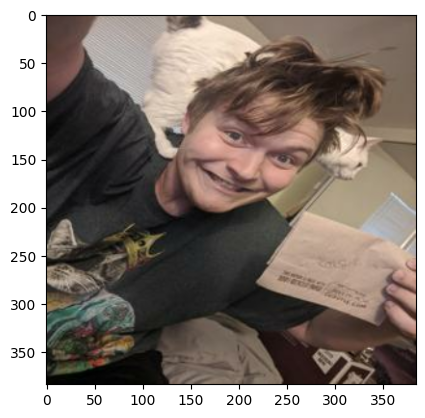

Sequence: tf.Tensor(
[   2  248  923   41  162 1395  115   13 1641  193   12 1243  332    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int32)
Caption: ['<start>', 'stop', 'putting', 'so', 'much', 'effort', 'into', 'that', 'comb', 'over', 'and', 'quit', 'meth', '<end>']


In [146]:
img = show_example(roast_val_dataset, roast_tokenizer)

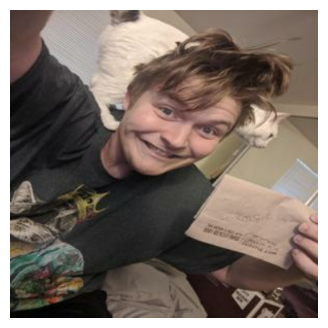

Image size: 384 X 384
Patch size: 16 X 16
Patches per image: 576
Elements per patch: 768


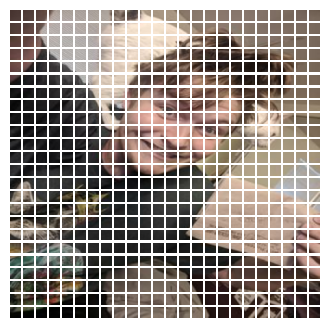

In [147]:
image_size = 384
patch_size = 16
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.show()

In [118]:
roast_tokenizer.index_word[3]

'<end>'

In [119]:
def eval_model(print_freq=200):
    start = time.time()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for (batch, (inp, tar)) in tqdm(enumerate(roast_test_dataset)):
        test_step(inp, tar)
        
        if batch % print_freq == 0:
            print(f'Test step: Epoch {current_epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')
    print('Eval loss:', test_loss)
    print('Eval accuracy:', test_accuracy)
#eval_model()

Encoder input: tf.Tensor(
[[[[0.42352942 0.40392157 0.38039216]
   [0.44972426 0.43011642 0.406587  ]
   [0.46624795 0.4466401  0.4231107 ]
   ...
   [0.33333334 0.32941177 0.30980393]
   [0.33333334 0.32941177 0.30980393]
   [0.33333334 0.32941177 0.30980393]]

  [[0.42090994 0.40130207 0.37777266]
   [0.44710478 0.42749694 0.40396753]
   [0.46479836 0.44519052 0.4216611 ]
   ...
   [0.3254749  0.32155332 0.30194548]
   [0.3254749  0.32155332 0.30194548]
   [0.3254749  0.32155332 0.30194548]]

  [[0.4178564  0.39824855 0.37471914]
   [0.44522116 0.4256133  0.4020839 ]
   [0.46407783 0.44447    0.42094058]
   ...
   [0.32156864 0.31764707 0.29803923]
   [0.32156864 0.31764707 0.29803923]
   [0.32156864 0.31764707 0.29803923]]

  ...

  [[0.6309539  0.48585588 0.32115   ]
   [0.61261755 0.4675195  0.3028136 ]
   [0.6122601  0.46716204 0.30245617]
   ...
   [0.23921569 0.19215687 0.10588235]
   [0.23791361 0.19085477 0.10458027]
   [0.23529412 0.1882353  0.10196079]]

  [[0.6261489  0.48

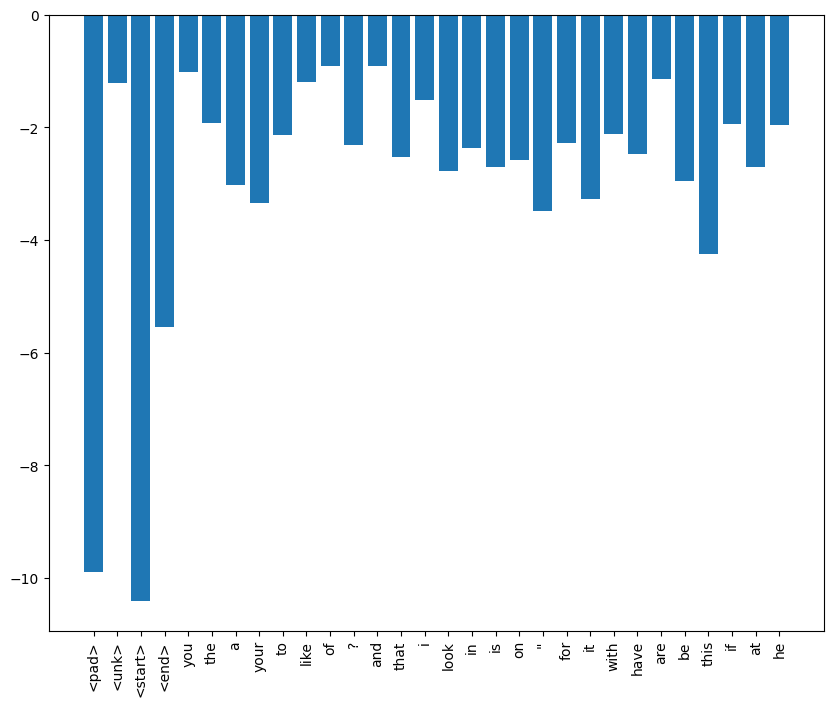

Argmax: tf.Tensor([[10]], shape=(1, 1), dtype=int32)
Prediction: of


In [120]:
with tf.device('/cpu:0'):
    plot_predictions(img, roast_tokenizer, start_text='Only', subset=30)

In [126]:
with tf.device('/cpu:0'):
    text, attention_weights = generate_roast(img, roast_tokenizer, temperature=1., start_text=None)
text

Found end
(1, 31)


'<start> gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt gt <end>'

In [149]:
with tf.device('/cpu:0'):
    print_input_pred(img, roast_tokenizer, start_text="this is a test to see if the neural network repeats itself, I believe that it will but we shall see")

tf.Tensor(
[[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.

In [70]:
roast_tokenizer.index_word[1]

'<unk>'

In [ ]:
transformer.save_weights('./checkpoints/transformer_base_model_2')

In [ ]:
import glob

[files.download(file) for file in glob.glob('./checkpoints/*')];